<h1> AXIVERSE MACHINE, ARBITRARY PRECISION </h1>

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker
import numpy as np
from scipy.sparse import spdiags
import scipy as sp
import pandas as pd
from matplotlib import rc
import csv
import pylab as p
from tqdm import tqdm
from decimal import *
from mpmath import mp
import gmpy2
from gmpy2 import mpfr, mpc
import flamp as fp

<h2>Utility functions</h2>

In [2]:
def stf(s):
    return str(s)
stv = np.vectorize(stf)
mpfv = np.vectorize(mp.mpf)

def mpf_to_gmpy2(ar):
    return fp.to_mp(stv(ar))
    
def gmpy2_to_mpf(ar):
    return mpfv(stv(ar))

def to_float(ar):    
    out = np.array([complex(str(x)) for x in ar.flatten()]).reshape(np.shape(ar))
    if np.imag(out).any() != 0:
        return out
    else: 
        return np.array([float(str(x)) for x in ar.flatten()]).reshape(np.shape(ar))

#Generate a random list
def mpfrand(n):
    out = mpf_to_gmpy2(np.array([mp.rand() for _ in range(np.prod(n))]))
    return fp.to_mp(out.reshape(n))
    
#Generate a random orthogonal matrix
def Random_Rotation_Matrix(n):
    r = mpf_to_gmpy2(mpfrand((n,n)))
    return fp.eigh(r + r.transpose())[1]


<h2>Physics functions</h2>

In [3]:
#The scalar potential
def V0(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    return np.sum(La * fp.cos(np.matmul(nd,fields) + ph))
#Its first derivative
def V1(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    return np.matmul(-La * fp.sin(np.matmul(nd,fields) + ph),nd)
def V1np(fields, parameters, nd0):
    La = parameters['Lambdas_float']
    ph = parameters['phases_float']
    return np.matmul(-La * np.sin(np.matmul(nd0,fields) + ph),nd0)
#Its second derivative
def V2(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    out = np.matmul(nd.transpose(),np.matmul(np.diag(-La * fp.cos(np.matmul(nd,fields) + ph)),nd))
    return (out+out.transpose())/2

#This function defines the equation of motion
def IVP_Function(t,state):
    positions = state[:N]
    velocities = state[N:]
    position_dot = velocities
    V1_eval = V1np(positions, parameters, nd0)
    if N_fixed > 0: #This if-else statement is to avoid throwing an error when N_fixed = 0 and m2[0] may be negative.
        velocity_dot_heavy = -V1_eval[:N_fixed] * (m2[N_fixed-1]/m2[:N_fixed]) -velocities[:N_fixed] * (2 * m2[N_fixed-1]**0.5)
    else:
        velocity_dot_heavy = -V1_eval[:N_fixed]
    velocity_dot_light = -V1_eval[N_fixed:] - 1.5 * velocities[N_fixed:]/t
    velocity_dot = np.concatenate((velocity_dot_heavy,velocity_dot_light))
    return np.concatenate((position_dot,velocity_dot))

In [18]:
#SET PRECISION
PREC = 30

#NUMBER OF AXIONS
N = 100

#TRIVIAL POTENTIAL
Trivial = False
#TRIVIAL INITIAL CONDITIONS:
TrivialIC = False

#FRACTIONAL DENSITY FLUCTUATION THRESHOLD FOR INTEGRATING OUT A PARTICLE
threshold = 0.01

#DOMAIN WALL NUMBERS (if not trivial)
NDW_range = 2 #Absolute value of the maximum domain wall number
p0 = (4)/N #Probability that NDW = 0

#INSTANTONS
M = 2 * N #Number of instantons
MUV = 1 #Scale of the UV physics
S0 = 100 #scale of the instanton actions



#~~~~~~~~~~~~~~~~~~~~~
#Calculated Quantities
#~~~~~~~~~~~~~~~~~~~~~


mp.dps = PREC
fp.set_precision(PREC)
fp.set_dps(PREC)

#DECAY CONSTANTS
f2 = fp.to_mp(np.random.rand(N)**2 * (1 - Trivial) + Trivial) #Squared decay constants
R = Random_Rotation_Matrix(N) * (1 - Trivial) + Trivial * fp.eye(N)

#Domain-wall numbers if random:
if Trivial:
    M = N + 0
    NDW_matrix = fp.eye(N)
    phase_list = fp.zeros([1,N])[0]
else:
    NDW_matrix = fp.to_mp(np.random.choice(range(-NDW_range,NDW_range + 1), size = (M,N), p = np.concatenate((0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range),p0 * np.ones(1),0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range)))))
    phase_list = 2 * np.pi * mpfrand(M)

exponent_distribution = np.exp(-S0 * np.random.rand(M))

#Packaging these parameters into a dictionary for easy reference
parameters = {'NDW' : NDW_matrix,
             'phases' : phase_list,
             'Lambdas' : fp.to_mp(MUV**4 * exponent_distribution),
             'NDW_float' : to_float(NDW_matrix),
             'phases_float' : to_float(phase_list),
             'Lambdas_float' : MUV**4 * exponent_distribution}

#Computing the rotation matrices
rotation_rescale = np.matmul(R.transpose(),np.diag(f2**-0.5))
rotation_rescale_inv = np.matmul(np.diag(f2**0.5),R)

#We now pick the initial condition for the fields. For now, I will assume the fundamental fields to be randomly distributed from 0 to 2 pi
theta_i = fp.to_mp(2 * np.pi * mpfrand(N) * (1 - TrivialIC) + 0.25 * np.pi * TrivialIC)
psi = np.matmul(rotation_rescale,theta_i)


<h2>Integrator</h2>

In [19]:
#Set up the initial problem by rotating into a canonically normlized (local) mass basis
N_steps = 1000000 #Number of t_i sized steps to take before checking whether to integrate out a mode

rho_list = fp.zeros([N,3])#This keeps track of the energy densities, the time of decoupling, and the masses.

#Calculating the rotation to the mass eigenbasis
m2,S = fp.eig(V2(psi, parameters, rotation_rescale))
#Mass Eigenbasis field at its initial condition
phi = np.matmul(S.transpose(),psi)

#Rotation matrix to the mass eigenbasis, as required for computing the gradient of the potential wrt the mass basis fields
rotation = np.matmul(rotation_rescale,S)
nd0 = to_float(np.matmul(parameters['NDW'],rotation))

#Use the mass eigenvalues as an estimate for the initial integration time i.e. t_0 ~ 1/m_max
t_0 = 0.01/np.max(np.abs(m2)**0.5)

#Now define the initial value problem:
initial_state = np.concatenate((phi,np.zeros(N)))

t_i,t_step = t_0 + 0,N_steps * t_0
t_f = t_step + 0
max_step = 10 * t_0
N_fixed = 0 #This variable will count the number of fields which we have integrated out -- initialized at 0
with tqdm(total=N, position=0, leave=True) as pbar:
    while N_fixed < N:
        if any(np.imag(to_float(m2))) != 0:
            print('Numerical precision too small.')
        #Integrate the system for two decades beyond t = 1/m_max
        solution = sp.integrate.solve_ivp(IVP_Function, to_float(np.array([t_i,t_f])), to_float(initial_state), max_step = to_float(np.array([max_step]))[0])
        phi_of_t,phi_dot_of_t = solution.y[:N].transpose(),solution.y[N:].transpose()
        
        #We now compute the energy density using the mass eigenvalues computed
        lt = len(solution.t)#//2
        t_list,rho_m = solution.t[-lt:],np.zeros([lt,N])
        m2,S = fp.eigh(V2(phi_of_t[-1], parameters, rotation))
        idx = np.argsort(np.abs(to_float(m2)))[::-1]
        m2,S = m2[idx],S[:,idx]
        rotation = np.matmul(rotation,S)
        nd0 = to_float(np.matmul(parameters['NDW'],rotation))
        Sf = to_float(S).transpose()
        i = -lt
        for t in solution.t[-lt:]:
            phi,phi_dot = np.matmul(Sf,phi_of_t[i]),np.matmul(Sf,phi_dot_of_t[i])
            delta_phi = V1np(phi, parameters, nd0)
            rho_m[i] = 0.5 * (phi_dot**2 + m2**-1 * delta_phi**2)
            i += 1
        # for j in range(N_fixed,N):
        #     plt.plot(np.log10(t_list),np.log10(rho_m[:,j] * t_list**1.5),color = plt.colormaps['Dark2'](j))
        FDF = np.std(rho_m[:,N_fixed] * t_list**1.5)/np.mean(rho_m[:,N_fixed] * t_list**1.5)
        initial_state = np.concatenate((phi,phi_dot))
        if FDF > threshold or m2[N_fixed] < 0:
            t_i,t_f = t_f + 0,t_f + t_step
        elif N_fixed < N:
            while N_fixed < N and FDF < threshold and m2[N_fixed] > 0 and FDF > 0:
                FDF = np.std(rho_m[:,N_fixed] * t_list**1.5)/np.mean(rho_m[:,N_fixed] * t_list**1.5)
                rho_list[N_fixed,:] = np.array([rho_m[-1,N_fixed],t_f,m2[N_fixed]**0.5])
                N_fixed += 1
                pbar.update(1)
            max_step = 0.1 * m2[N_fixed - 1]**-0.5
            t_i = t_f + 0
            t_step = 10**-3 * N_steps * m2[N_fixed - 1]**-0.5
            t_f = t_f + t_step
        else:
            N_fixed += 1
rho_normalized = np.zeros([N,2])
for i in range(N):
    rho_normalized[i] = [rho_list[i,2],rho_list[i,0] * (rho_list[i,1]/rho_list[-1,1])**1.5]

100%|█████████████████████████████████████████| 100/100 [04:11<00:00,  2.51s/it]


(array([30., 27., 19., 15.,  2.,  2.,  1.,  0.,  1.,  2.]),
 array([0.01104314, 0.13768479, 0.26432643, 0.39096808, 0.51760973,
        0.64425138, 0.77089303, 0.89753467, 1.02417632, 1.15081797,
        1.27745962]),
 <BarContainer object of 10 artists>)

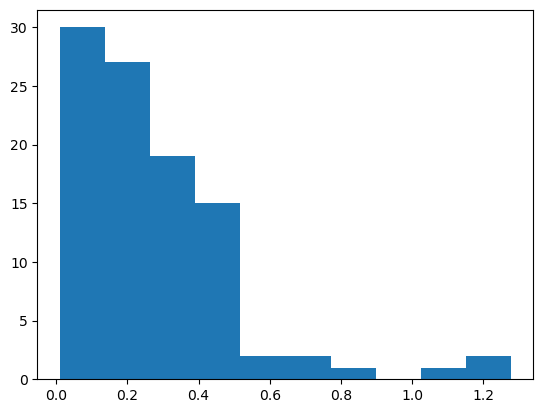

In [20]:
m2f = to_float(m2)
dm2f = to_float(np.array([x/y for x,y in zip(m2f[:-1],m2f[1:])]))
plt.hist(np.log10(dm2f))

Text(0, 0.5, 'log energy density [arbitrary units]')

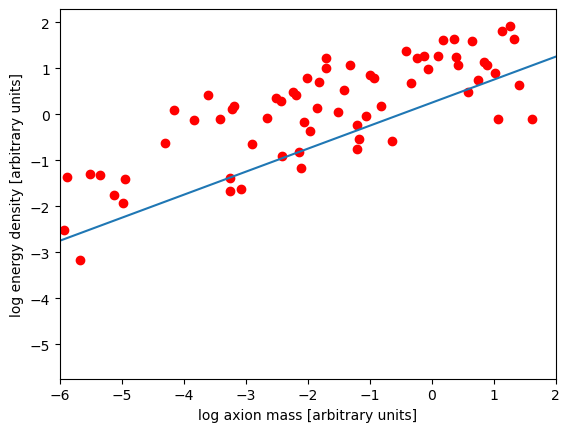

In [23]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

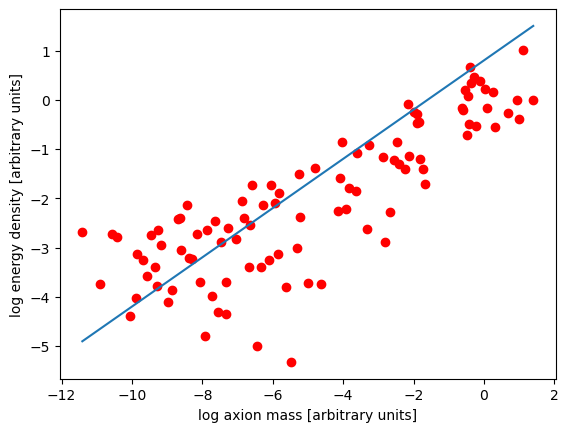

In [12]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5)+1.5)
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

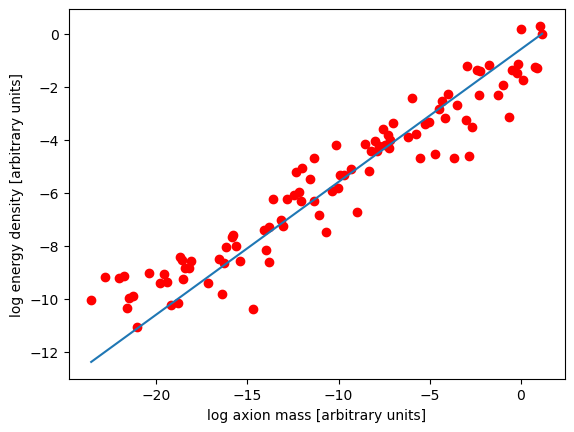

In [7]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

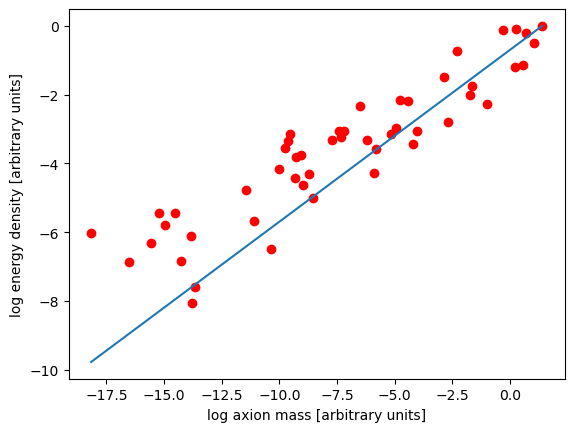

In [10]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

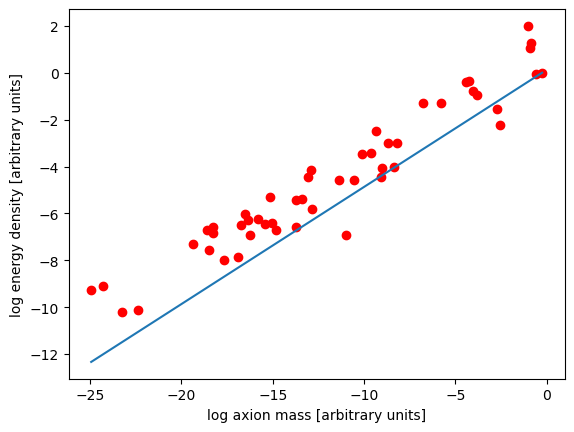

In [42]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

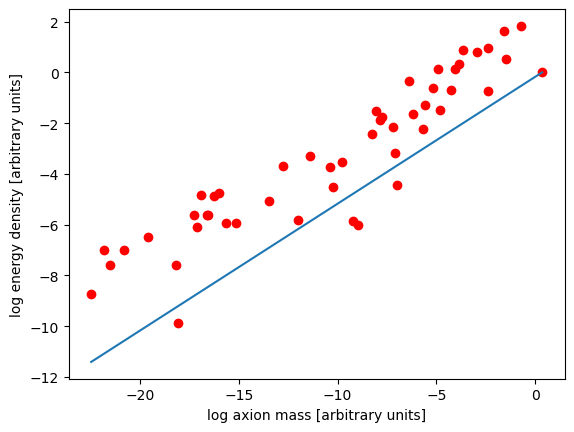

In [39]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

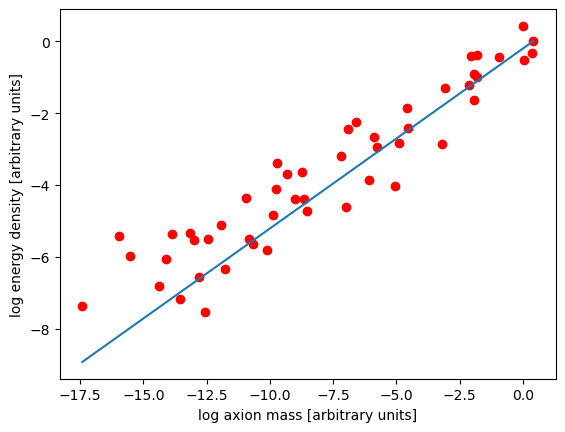

In [31]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

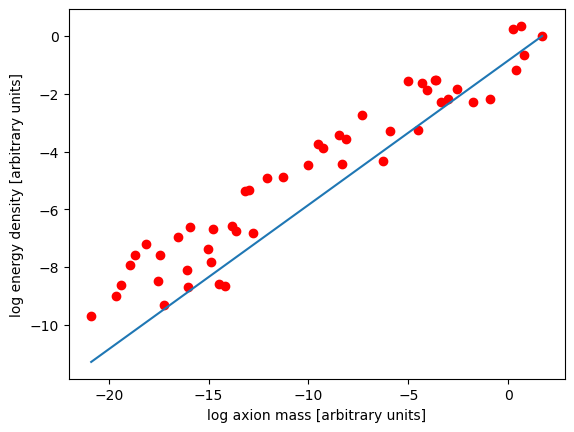

In [28]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

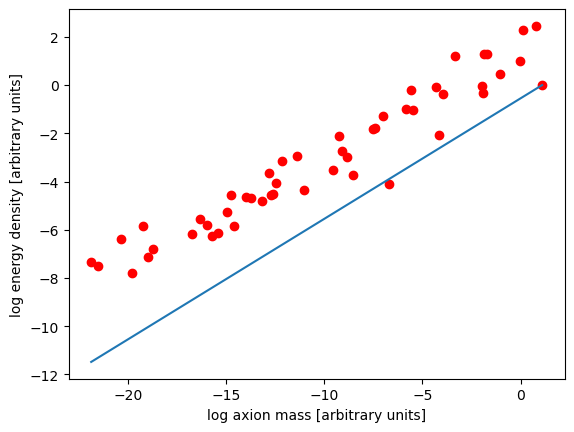

In [25]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

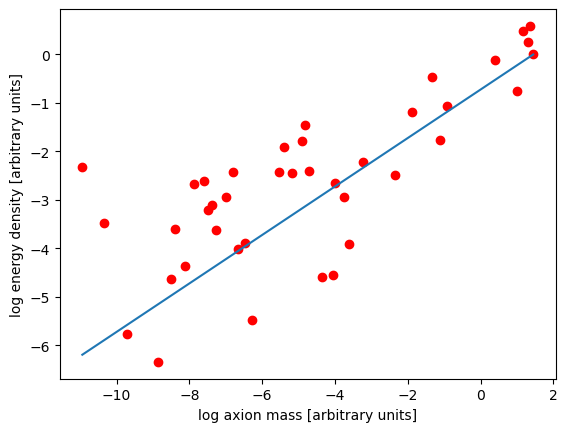

In [22]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

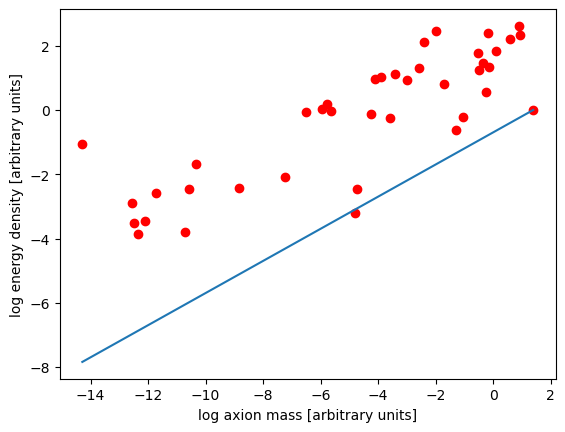

In [30]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

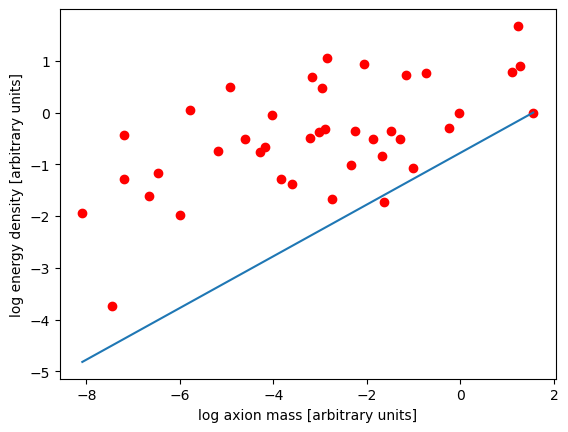

In [27]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

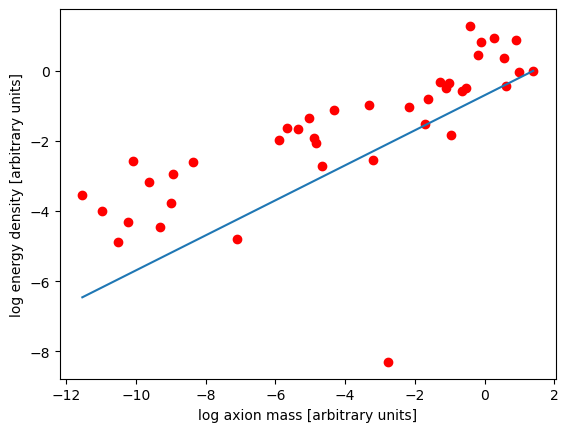

In [18]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

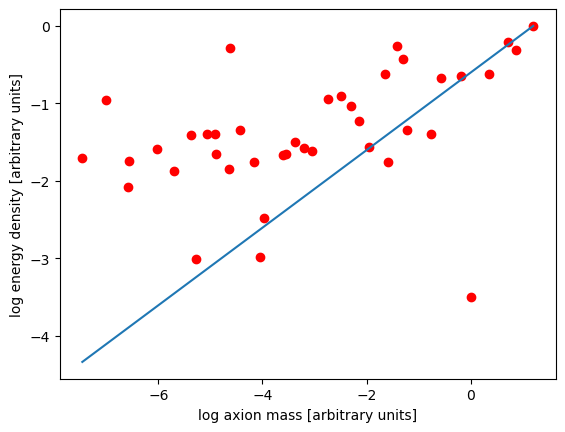

In [15]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

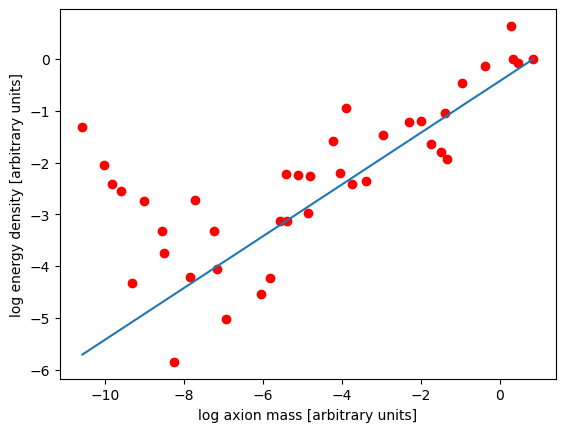

In [12]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

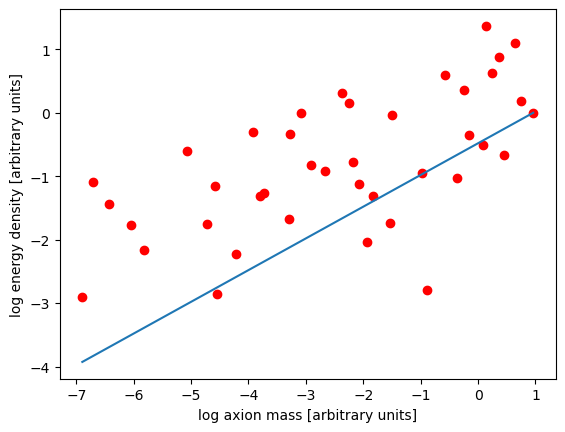

In [22]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

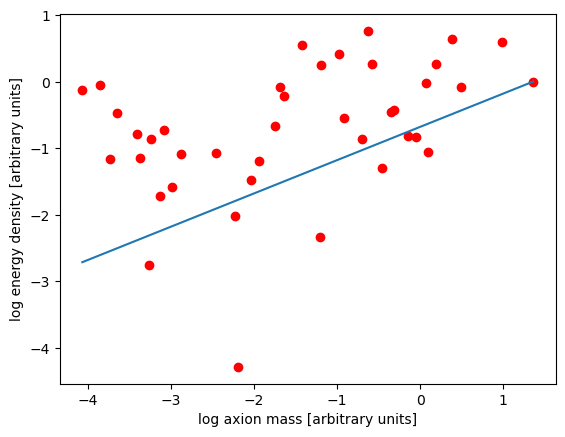

In [19]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

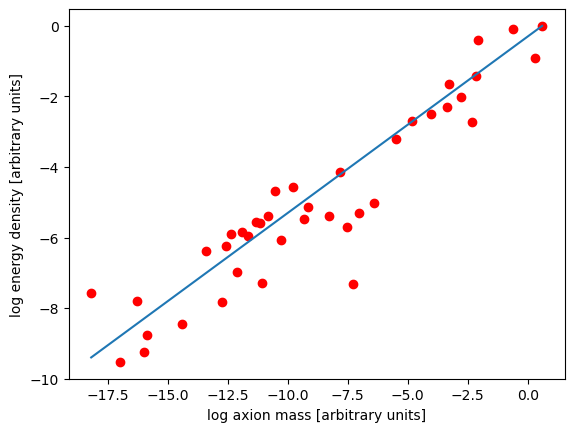

In [11]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

In [23]:
N_fixed

40